## Monte Carlo Dropout based Uncertainty Estimation

credits: https://www.youtube.com/c/DeepFindr 

In [1]:
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.pyplot import scatter, figure
import math
import numpy as np
figure(figsize=(9, 7))

import pandas as pd 
import seaborn as sns
sns.set(rc={'figure.figsize':(9, 7)})

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F

device = "cpu"


<Figure size 900x700 with 0 Axes>

## Generating fake 1D Regression dataset

### Train Dataset (-7 to 7)

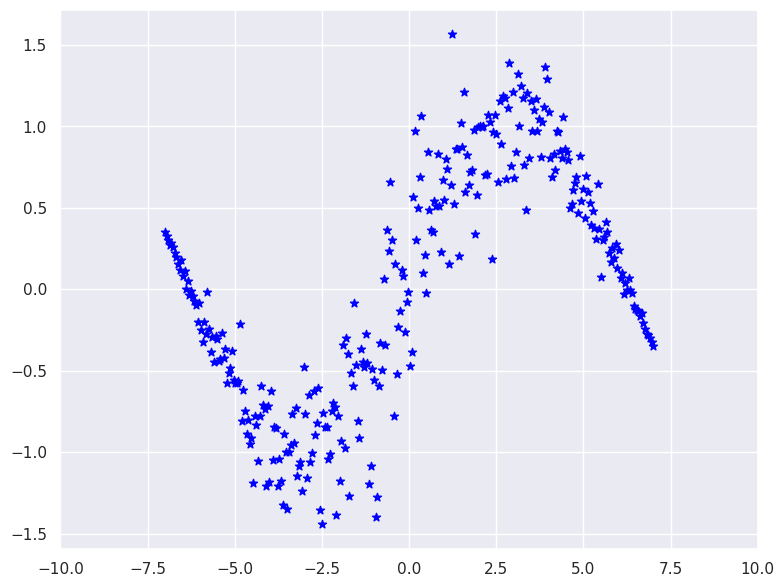

In [2]:
# Same range for all plots
plt.xlim([-10, 10])
start = -7
end = 7
n = 300

def sample_dataset(start, end, n):
    x = np.linspace(start, end, n)
    sample_mean = [math.sin(i/2) for i in x]
    sample_var = [((abs(start)+abs(end))/2 - abs(i))/16 for i in x]
    y = stats.norm(sample_mean, sample_var).rvs()
    return x, y

x_train, y_train = sample_dataset(start, end, n)
scatter(x_train, y_train, c="blue", marker="*")

### Test Dataset (-10 to 10)

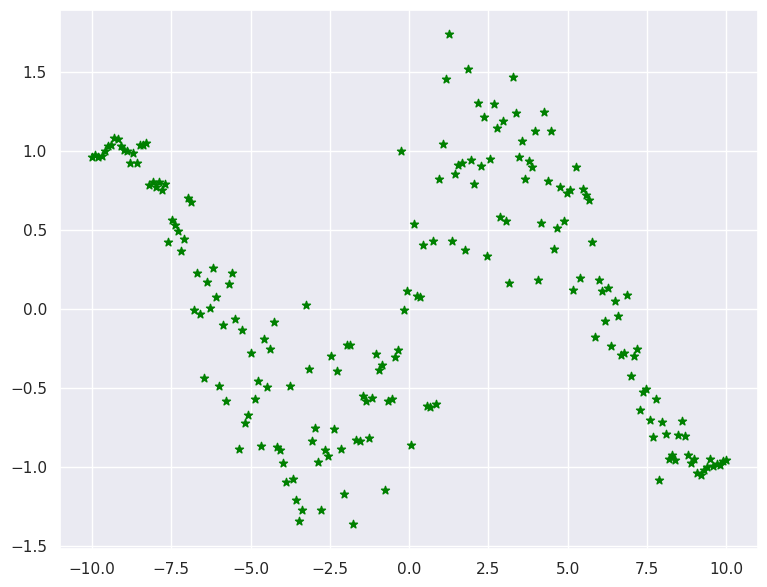

In [3]:
figure(figsize=(9, 7))
# Not exactely the same distribution, but works for now
x_test, y_test = sample_dataset(-10, 10, 200)
scatter(x_test, y_test, c="green", marker="*")

### Creating train and test dataloaders

In [4]:

batch_size = 16

# Train
tensor_x = torch.Tensor(x_train).unsqueeze(1)
tensor_y = torch.Tensor(y_train).unsqueeze(1)
train_dataset = TensorDataset(tensor_x, tensor_y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Test
tensor_x_test = torch.Tensor(x_test).unsqueeze(1)
tensor_y_test = torch.Tensor(y_test).unsqueeze(1)
test_dataset = TensorDataset(tensor_x_test, tensor_y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

## Monte Carlo Dropout method




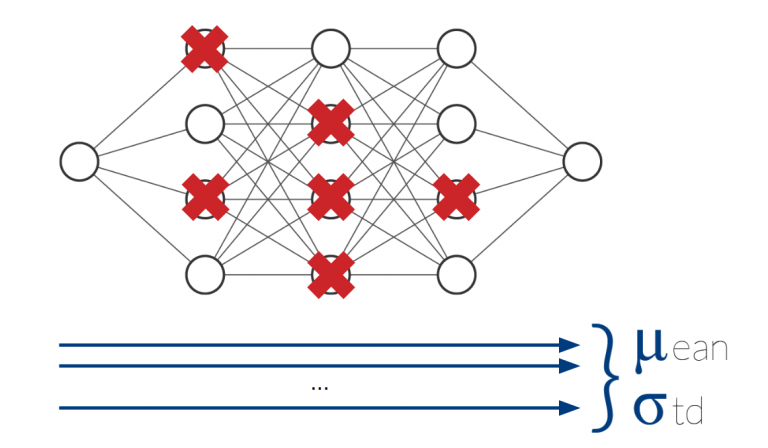

Credits: https://www.inovex.de/de/blog/uncertainty-quantification-deep-learning/

### Creating Simple Linear Model

In [5]:
from numpy.ma.core import outer
from sys import stderr
import torch.nn as nn
import torch.nn.functional as F

class Simple_Dropout(nn.Module):
    def __init__(self):
        super(Simple_Dropout, self).__init__()
        hidden_size = 32

        # We only have 1 input feature
        self.fc1 = nn.Linear(1, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, x):
        h = self.dropout(torch.relu(self.fc1(x)))
        h = self.dropout(torch.relu(self.fc2(h)))
        out = self.out(h)
        return out

model = Simple_Dropout()
print(model)
print("Params:", sum(p.numel() for p in model.parameters() if p.requires_grad))

Simple_Dropout(
  (fc1): Linear(in_features=1, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)
Params: 1153


### Plotting Function

In [6]:
def plot_graphs(model, IPEX, samples = 50):
    # Keep dropout active!
    model.train()
    
    if IPEX:
        import intel_extension_for_pytorch as ipex
        model = ipex.optimize(model)
    
    t1 = time.time()
    preds = [model(tensor_x_test) for i in range(samples)]
    test_time = time.time() - t1
    
    print(test_time)
    
    preds = torch.stack(preds)
    means = preds.mean(axis=0).detach().numpy()
    stds =  preds.std(axis=0).detach().numpy()
    dfs = []
    y_vals = [means, means+2*stds, means-2*stds]

    for i in range(3):
      data = {
            "x": list(tensor_x_test.squeeze().numpy()),
            "y": list(y_vals[i].squeeze())
      }
      temp = pd.DataFrame.from_dict(data)
      dfs.append(temp)

    df = pd.concat(dfs).reset_index()

    # Plot predictions with confidence
    sns_plot = sns.lineplot(data=df, x="x", y="y")

    # Highligh training range
    plt.axvline(x=start)
    plt.axvline(x=end)

    # Plot train data on top
    scatter(x_train, y_train, c="green", marker="*", alpha=0.3)
    plt.show()

### Train and Testing loop

Epoch 0 | batch train loss: 0.45283570885658264 | test loss: 0.8713926604160895


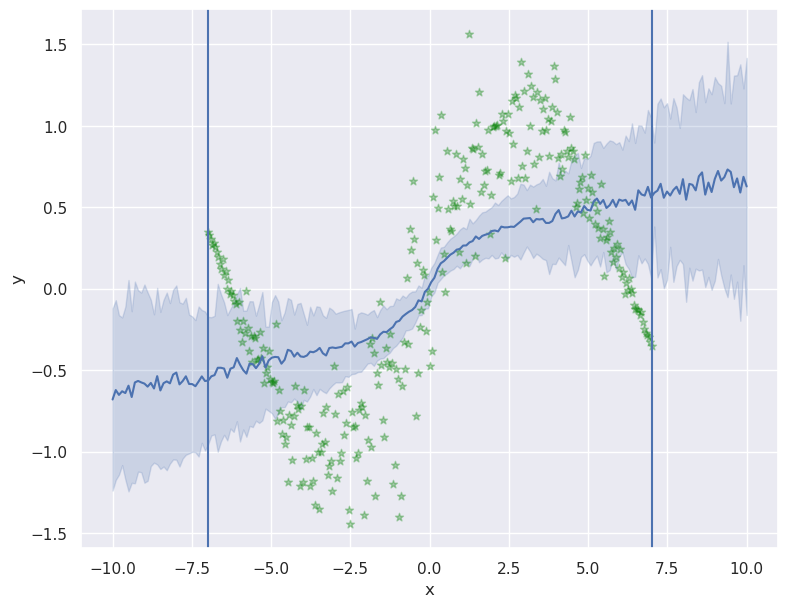

Epoch 10 | batch train loss: 0.07370904088020325 | test loss: 0.21879958991820997


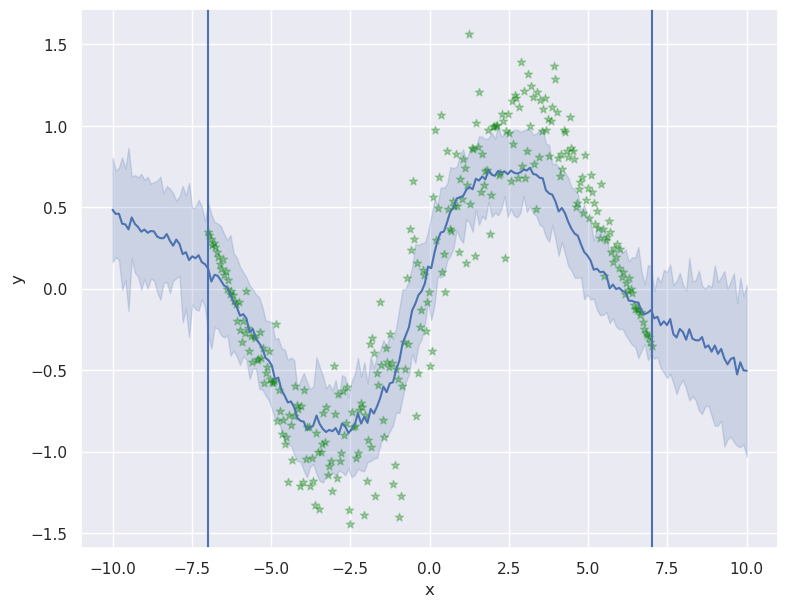

Epoch 20 | batch train loss: 0.13738586008548737 | test loss: 0.2095101745082782


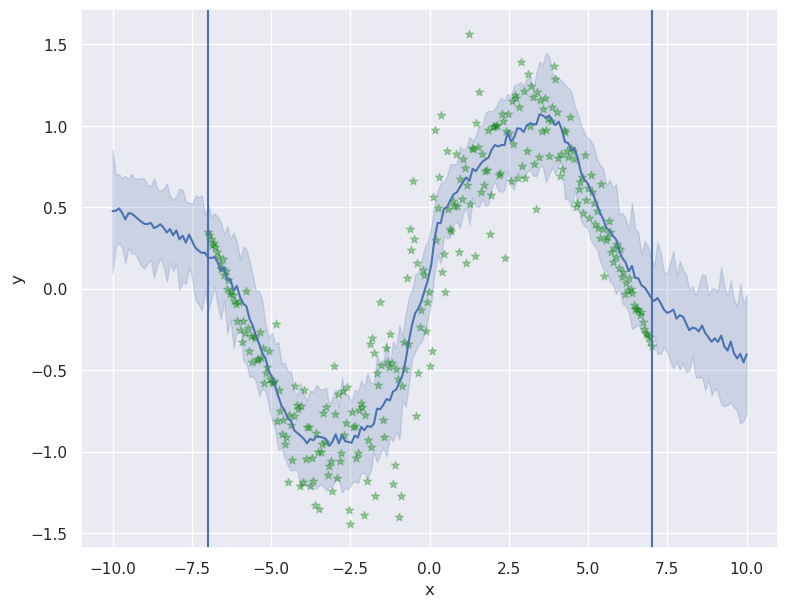

Epoch 30 | batch train loss: 0.06437303870916367 | test loss: 0.2129220228928786


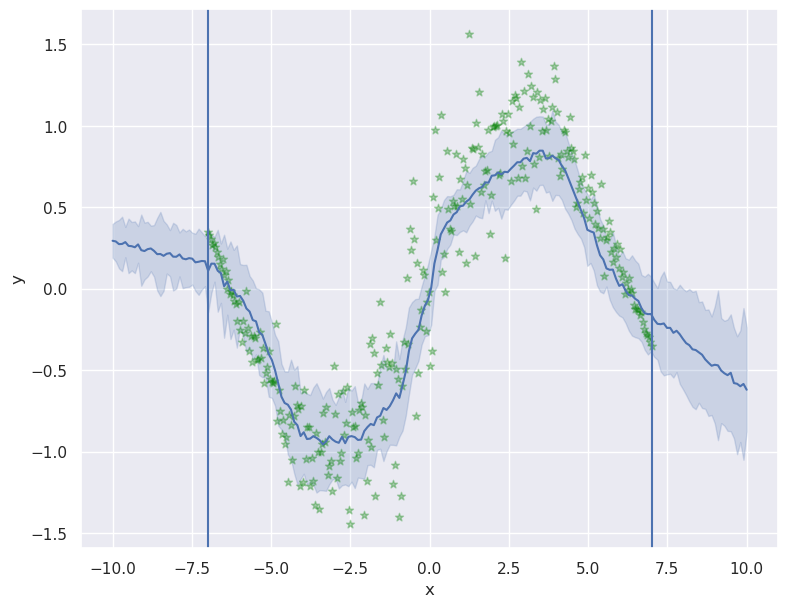

Epoch 40 | batch train loss: 0.09159967303276062 | test loss: 0.22936764875283608


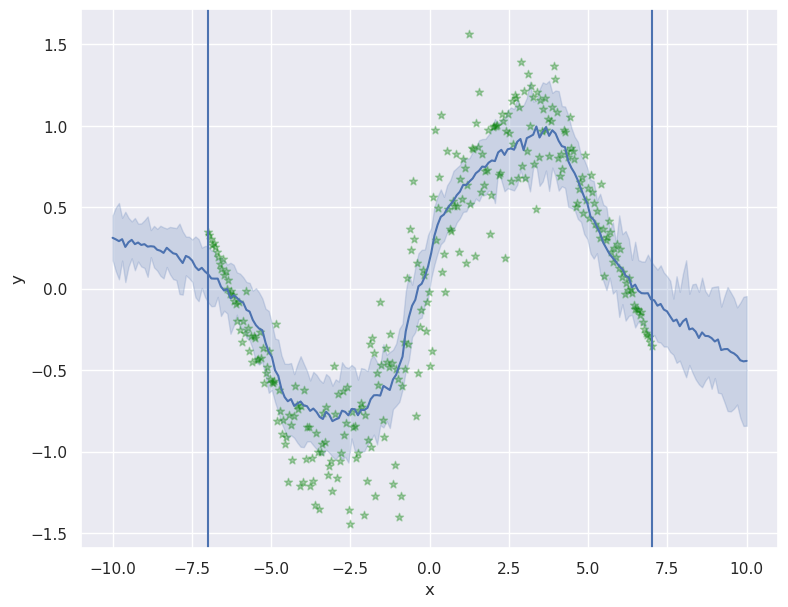

Epoch 50 | batch train loss: 0.10547780990600586 | test loss: 0.2141659569281798


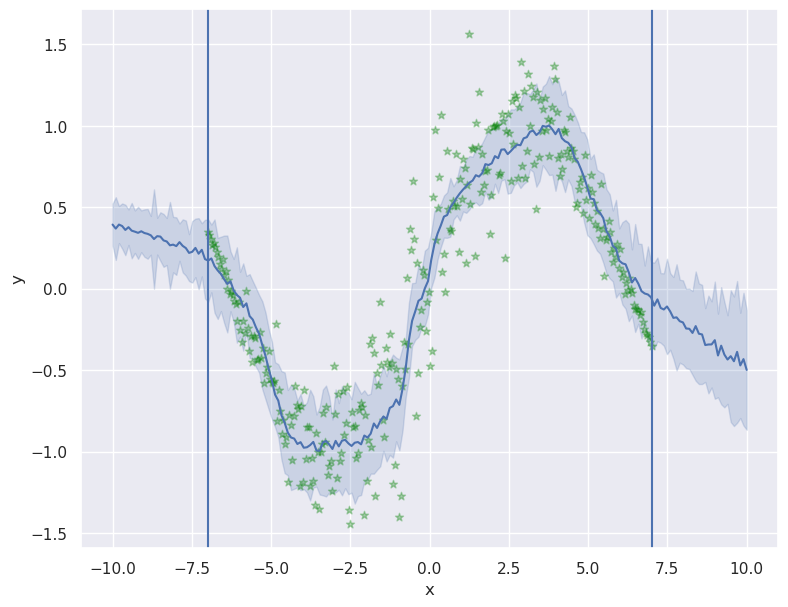

Epoch 60 | batch train loss: 0.08844124525785446 | test loss: 0.19266896637586448


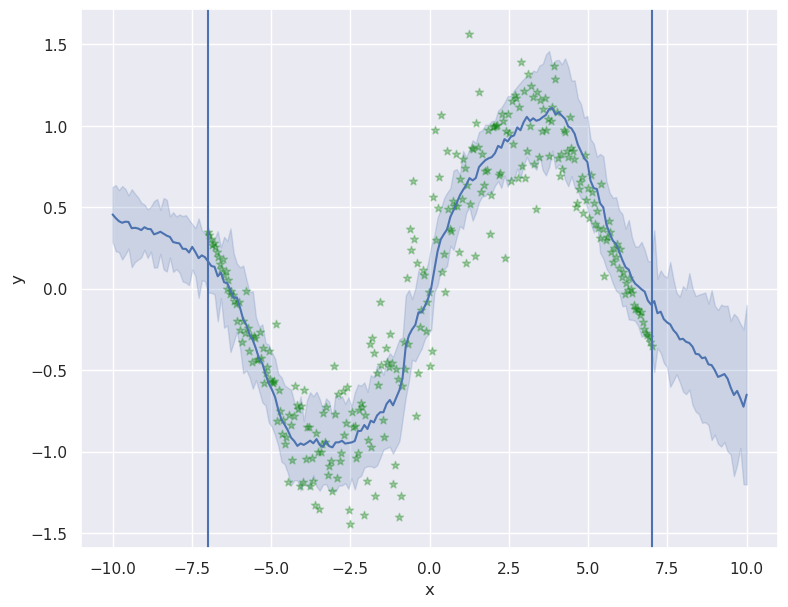

Epoch 70 | batch train loss: 0.07364816218614578 | test loss: 0.18572230809009993


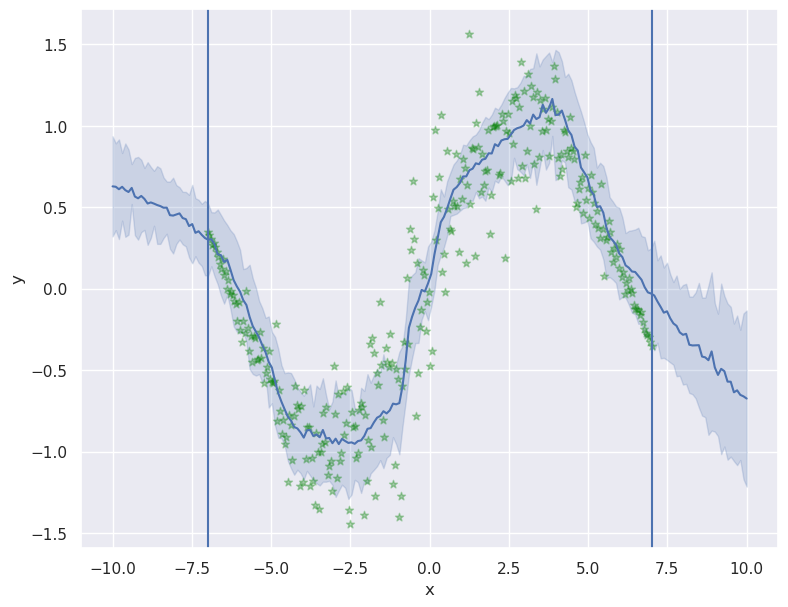

Epoch 80 | batch train loss: 0.04426009580492973 | test loss: 0.1727055603495011


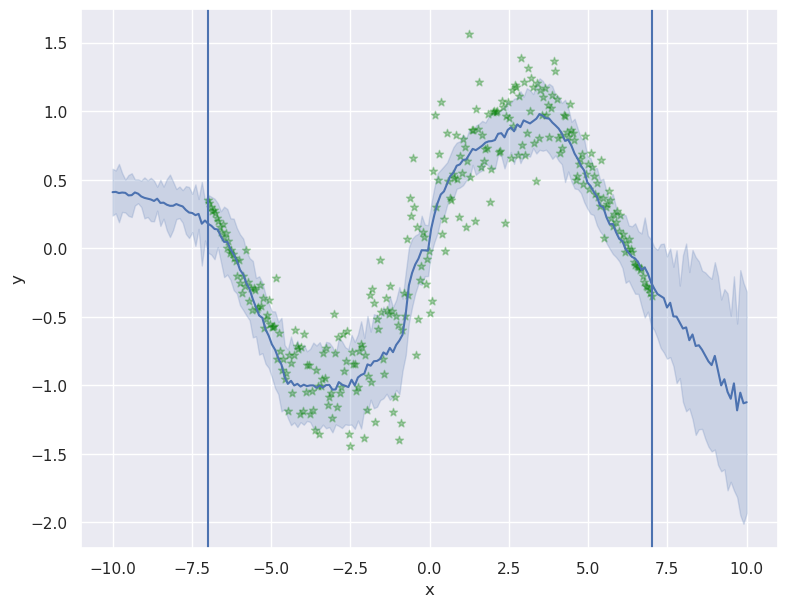

Epoch 90 | batch train loss: 0.059698570519685745 | test loss: 0.1858785800062693


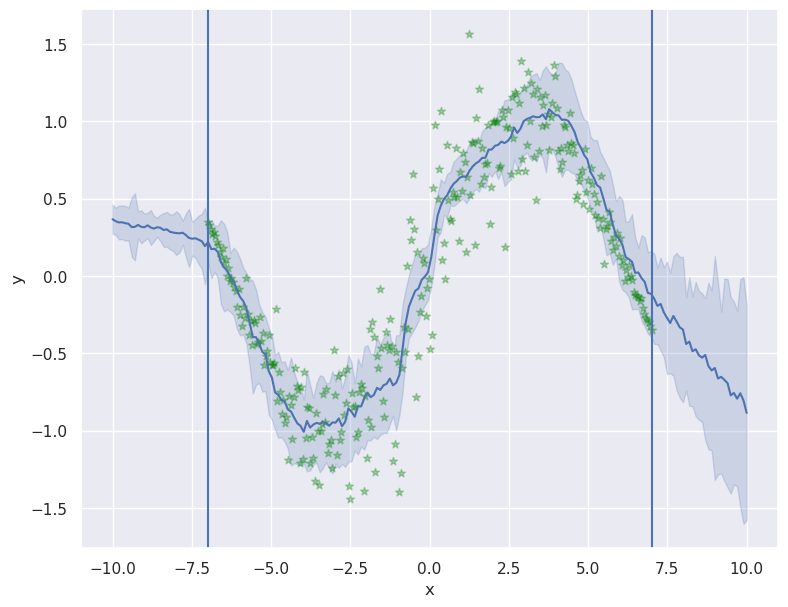

Epoch 100 | batch train loss: 0.09267666935920715 | test loss: 0.19156314661869636


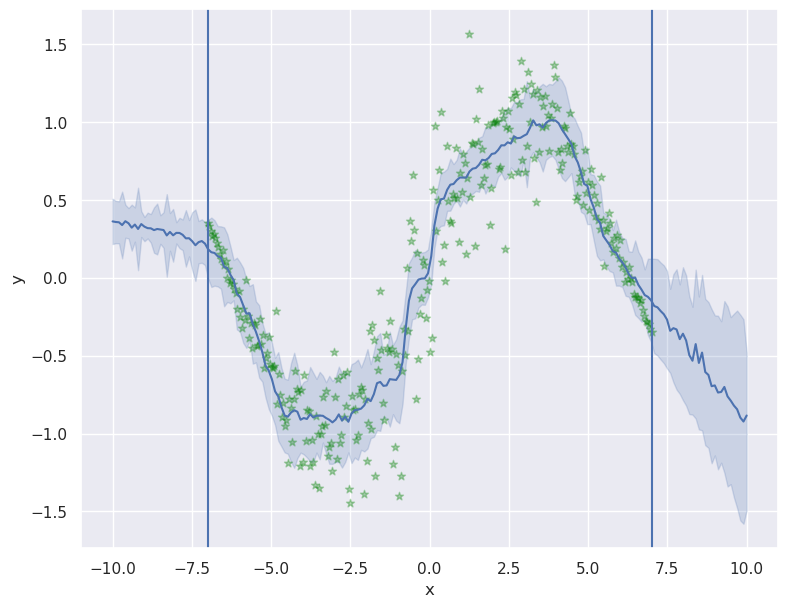

Epoch 110 | batch train loss: 0.10341835021972656 | test loss: 0.15443342522932932


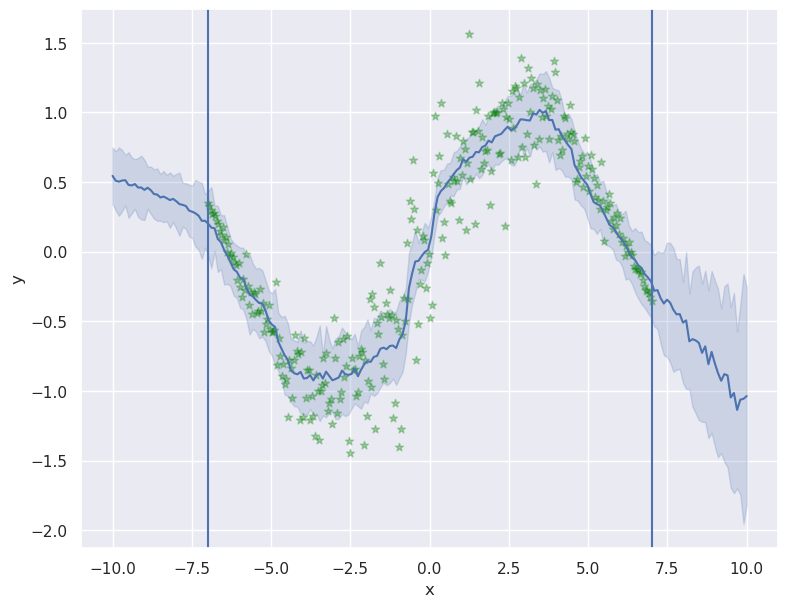

Epoch 120 | batch train loss: 0.0341794528067112 | test loss: 0.16644937315812477


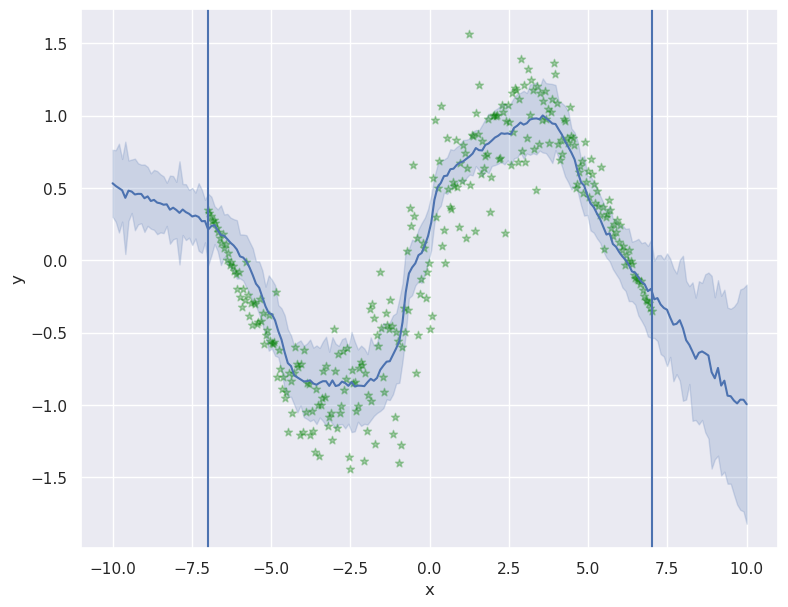

Epoch 130 | batch train loss: 0.049047425389289856 | test loss: 0.1734206137748865


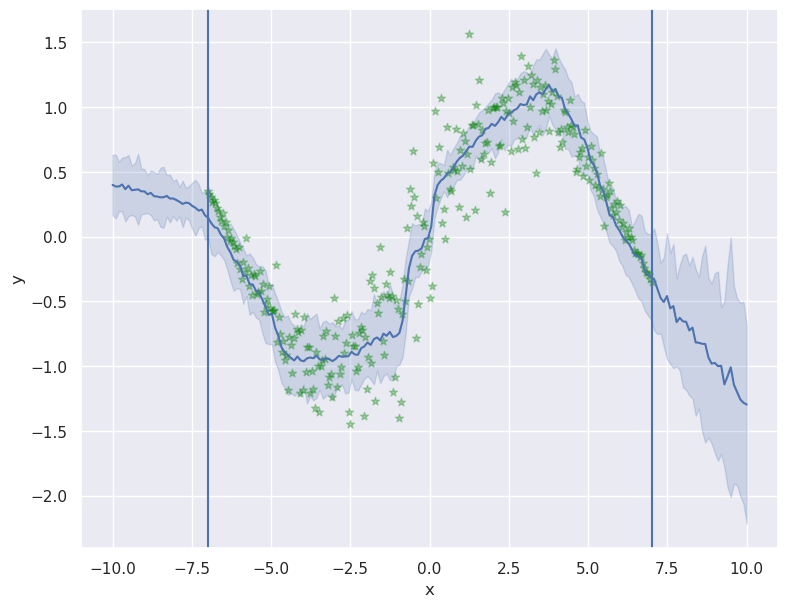

Epoch 140 | batch train loss: 0.13798530399799347 | test loss: 0.17554941716102454


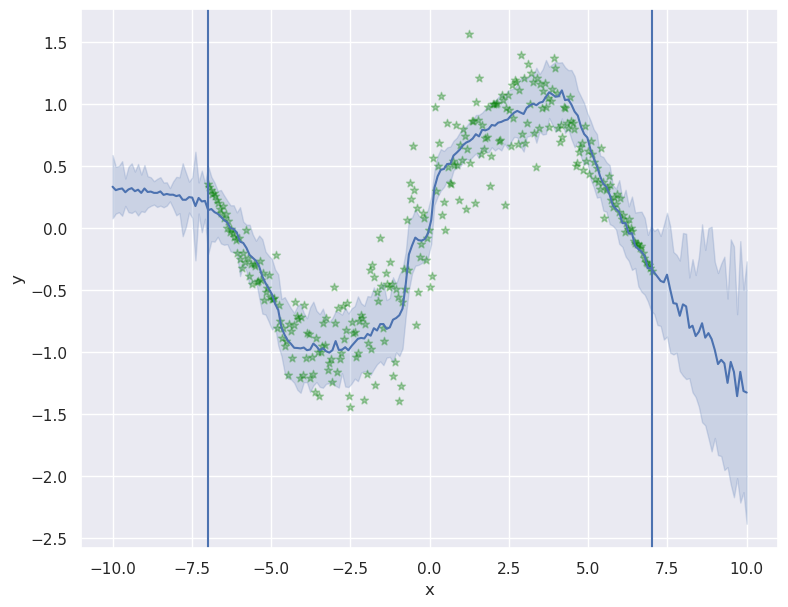

In [7]:
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
model.to(device)

for epoch in range(5):
    model.train()
    # Train loop
    for batch in train_loader:
        x = batch[0].to(device)
        y = batch[1].to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(y, out)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        all_test_losses = []
        # Test loop
        for batch in test_loader:
             x = batch[0].to(device)
             y = batch[1].to(device)

             # Sample MC Dropout predictions
             outs = []
             for i in range(10):
                  out = model(x)
                  outs.append(out)
              
             # Take mean prediction
             out = sum(outs)/len(outs)
             all_test_losses.append(criterion(y, out).item())
        test_loss = sum(all_test_losses)/len(all_test_losses)
        print(f"Epoch {epoch} | batch train loss: {loss} | test loss: {test_loss}")
        
        IPEX=False
        plot_graphs(model, IPEX)
        IPEX=True
        plot_graphs(model, IPEX)
